<a href="https://colab.research.google.com/github/paulynamagana/AFDB_notebooks/blob/main/AFDB_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Accessing AlphaFold DB structures via API**

<img src="https://github.com/paulynamagana/AFDB_notebooks/blob/main/api.png?raw=true" height="200" align="right">

Welcome to this notebook! In this tutorial, we will walk you through the process of accessing the AlphaFold Protein Structure Database using the API (Application Programming Interface).

For more information on the API endpoints, visit the docs on the [AlphaFold Database](https://alphafold.ebi.ac.uk/api-docs)

An API serves as a bridge, enabling seamless communication between different software systems. With AFDB API, you can easily retrieve information about protein structures predicted by AlphaFold, such as URLs to model files (mmCIF, bCIF and PDB), models quality estimates, and other useful information. All the API endpoints are keyed on UniProt accessions.

To use this Colab notebook, you will need to have a Google account and be logged in to Google Colab.

<br>




---


  ## How to use Google Colab <a name="Quick Start"></a>
1. To run a code cell, click on the cell to select it. You will notice a play button (▶️) on the left side of the cell. Click on the play button or press Shift+Enter to run the code in the selected cell.
2. The code will start executing, and you will see the output, if any, displayed below the code cell.
3. Move to the next code cell and repeat steps 2 and 3 until you have executed all the desired code cells in sequence.
4. The currently running step is indicated by a circle with a stop sign next to it.
If you need to stop or interrupt the execution of a code cell, you can click on the stop button (■) located next to the play button.

*Remember to run the code cells in the correct order, as their execution might depend on variables or functions defined in previous cells. You can modify the code in a code cell and re-run it to see updated results.*

---
# Notes

As of July 2025, there has been an update to the AFDB API predictions endpoint, you can read more about the changes [here](https://www.ebi.ac.uk/pdbe/news/breaking-changes-afdb-predictions-api)

In [ ]:
#@title ##1.&nbsp;  <font color='#2895ef'>Get predicted model from AFDB for an UniProt accession
import requests, json

#@markdown This block will retrieve the data for a UniProt accession and will display the 3D structure with the PAE.
uniprot_accession = "P00520" #@param {type:"string"}
#@markdown Note: For visualising structures with interactive PAE viewer, visist the [AlphaFold Protein Structure Database](https://alphafold.ebi.ac.uk/api-docs)


!pip install py3Dmol
import py3Dmol
import requests
from IPython.display import display, Image
import json
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import re
import os
import zipfile

def fetch_af_data(uniprot_accession):
  """
    Fetches metadata from the AlphaFold Database API.
    Returns the full JSON result.
  """

  api_endpoint = "https://alphafold.ebi.ac.uk/api/prediction/"
  url = f"{api_endpoint}{uniprot_accession}"

  try:
    response = requests.get(url, timeout=10)
    if response.status_code == 200:
      result = response.json()
      print(json.dumps(result, indent=2))
      return result
    else:
      response.raise_for_status()

  except requests.exceptions.RequestException as e:
    print(f"Error: {e}")


result = fetch_af_data(uniprot_accession)



[
  {
    "toolUsed": "AlphaFold Monomer v2.0 pipeline",
    "providerId": "GDM",
    "entityType": "protein",
    "isUniProt": true,
    "modelEntityId": "AF-P00520-F1",
    "modelCreatedDate": "2025-08-01T00:00:00Z",
    "sequenceVersionDate": "2005-02-15T00:00:00Z",
    "globalMetricValue": 63.44,
    "fractionPlddtVeryLow": 0.491,
    "fractionPlddtLow": 0.044,
    "fractionPlddtConfident": 0.092,
    "fractionPlddtVeryHigh": 0.374,
    "latestVersion": 6,
    "allVersions": [
      1,
      2,
      3,
      4,
      5,
      6
    ],
    "sequence": "MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTIYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVSAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGM

In [ ]:

#@markdown As of **2025** the AlphaFold Database include isoforms.<br>
#@markdown This code block will print a table of all available entries for that UniProt ID, which can include isoforms.

def format_date(date_str):
    if not date_str:
        return "N/A"
    try:
        return date_str.split('T')[0]
    except Exception:
        return date_str

print(f"All entries for the UniProt ID {uniprot_accession}:")

rows= []

for item in result:
    modelID = item.get("modelEntityId")
    description = item.get("uniprotDescription")
    modelCreatedDate = format_date(item.get("modelCreatedDate"))
    sequenceVersionDate = format_date(item.get("sequenceVersionDate"))
    latestVersion = item.get("latestVersion")
    average_plddt = item.get("globalMetricValue")
    fractionPlddtVeryLow = item.get("fractionPlddtVeryLow")
    fractionPlddtLow = item.get("fractionPlddtLow")
    fractionPlddtHigh = item.get("fractionPlddtConfident")
    fractionPlddtVeryHigh = item.get("fractionPlddtVeryHigh")
    UniprotReview = item.get("isUniProtReviewed")
    ReferenceStatus = item.get("isUniProtReferenceProteome")

    seq_str = item.get("sequence")
    seq_len = len(seq_str) if seq_str else 0

    rows.append({
        "model_ID": modelID,
        "description":description,
        "Length": seq_len,
        "Sequence_version_date": sequenceVersionDate,
        "Model_created_date": modelCreatedDate,
        "Average_plddt": average_plddt,
        "Latest_version": latestVersion,
        "FractionPlddt_VeryLow": "{:.1f}%".format(fractionPlddtVeryLow * 100),
        "FractionPlddt_Low": "{:.1f}%".format(fractionPlddtLow* 100),
        "FractionPlddt_High": "{:.1f}%".format(fractionPlddtHigh* 100),
        "FractionPlddt_VeryHigh": "{:.1f}%".format(fractionPlddtVeryHigh* 100),
        "UniprotReview": UniprotReview,
        "ReferenceStatus": ReferenceStatus
    })

df = pd.DataFrame(rows)
df


All entries for the UniProt ID P00520:


,model_ID,description,Length,Sequence_version_date,Model_created_date,Average_plddt,Latest_version,FractionPlddt_VeryLow,FractionPlddt_Low,FractionPlddt_High,FractionPlddt_VeryHigh,UniprotReview,ReferenceStatus
0,AF-P00520-F1,Tyrosine-protein kinase ABL1,1123,2005-02-15,2025-08-01,63.44,6,49.1%,4.4%,9.2%,37.4%,True,True
1,AF-P00520-4-F1,Tyrosine-protein kinase ABL1,1142,2005-02-15,2025-08-01,62.84,6,49.9%,4.6%,8.7%,36.8%,True,True
2,AF-P00520-3-F1,Tyrosine-protein kinase ABL1,1118,2005-02-15,2025-08-01,63.97,6,48.1%,5.1%,8.5%,38.3%,True,True
3,AF-P00520-2-F1,Tyrosine-protein kinase ABL1,1117,2005-02-15,2025-08-01,64.69,6,47.7%,3.9%,10.0%,38.3%,True,True


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

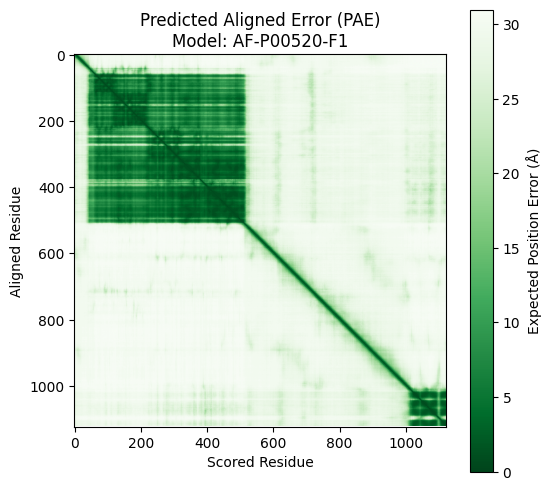

In [ ]:
#@markdown Now, choose one model ID to analyse the MSA.
#@markdown This code block will visualise the structure and the PAE plot
model_entity = "AF-P00520-F1"#@param {type:"string"}
plddt_scores = []

for entry in result:
    if entry["modelEntityId"] == model_entity:
        plddt_url = entry["plddtDocUrl"]
        pdbUrl = entry["pdbUrl"]
        paeDocUrl = entry["paeDocUrl"]
        v_high = entry['fractionPlddtVeryHigh']
        confident = entry['fractionPlddtConfident']
        low = entry['fractionPlddtLow']
        v_low = entry['fractionPlddtVeryLow']
        break
if not model_entity:
    print(f"Model {model_entity} not found in results.")

def plot_pae(pae_url):
    response = requests.get(pae_url)
    data = response.json()

    if isinstance(data, list) and len(data) > 0:
        pae_matrix = data[0]['predicted_aligned_error']
    else:
        print("Invalid PAE data format.")
        return

    # Plotting
    plt.figure(figsize=(6, 6))
    plt.imshow(pae_matrix, cmap='Greens_r', vmin=0, vmax=31)

    cb = plt.colorbar()
    cb.set_label('Expected Position Error (Å)')
    plt.title(f'Predicted Aligned Error (PAE)\nModel: {model}')
    plt.xlabel('Scored Residue')
    plt.ylabel('Aligned Residue')
    plt.grid(False)
    plt.show()

# Function to show protein structure and image
def show_structure_and_image(pdb_url, paeUrl, color="plDDT"):
    pdb_data = requests.get(pdb_url).text
    # Create a 3Dmol.js view
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
    # Add the PDB data to the view
    view.addModel(pdb_data, 'pdb')

    if color == "plDDT":
        view.setStyle({'cartoon': {'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 50, 'max': 90}}})
    elif color == "rainbow":
        view.setStyle({'cartoon': {'color': 'spectrum'}})

    # Zoom to the structure
    view.zoomTo()
    display(view) # Display
    plot_pae(paeUrl) # Display

show_structure_and_image(pdbUrl, paeDocUrl, "plDDT")



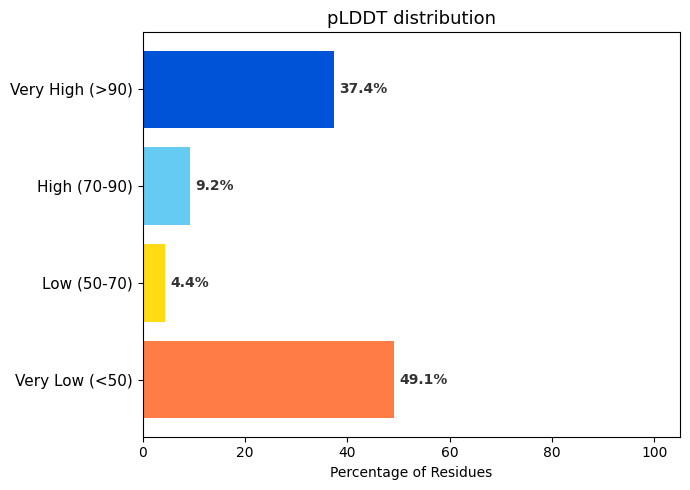

In [ ]:
#@markdown This code block will now plot the pLDDT distribution


def plot_plddt_distribution(fractionPlddtVeryHigh, fractionPlddtConfident, fractionPlddtLow, fractionPlddtVeryLow):
    """
    Plots the AlphaFold pLDDT distribution as a horizontal bar chart.
    Expects fraction values (0.0 - 1.0) as input.
    """
    # 1. Prepare Data
    labels = ['Very High (>90)', 'High (70-90)', 'Low (50-70)', 'Very Low (<50)']

    # Convert fractions to percentages
    sizes = [
        fractionPlddtVeryHigh * 100,
        fractionPlddtConfident * 100,
        fractionPlddtLow * 100,
        fractionPlddtVeryLow * 100
    ]

    # Standard AlphaFold Colors: Dark Blue, Light Blue, Yellow, Orange
    colors = ['#0053D6', '#65CBF3', '#FFDB13', '#FF7D45']

    fig, ax = plt.subplots(figsize=(7, 5))
    y_pos = range(len(labels))

    ax.barh(y_pos, sizes, color=colors, edgecolor='none')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=11)
    ax.invert_yaxis()

    ax.set_xlabel('Percentage of Residues')
    ax.set_title('pLDDT distribution', fontsize=13)
    ax.set_xlim(0, 105)

    for i, v in enumerate(sizes):
        label = f"{v:.1f}%" if v > 0 else ""
        ax.text(v + 1, i, label, va='center', fontweight='bold', color='#333333')

    plt.tight_layout()
    plt.show()

plot_plddt_distribution(v_high, confident, low, v_low)


In [ ]:

#@title ## Batch Download Multiple Models
#@markdown Enter a comma-separated list of Model IDs.
#@markdown (e.g. `AF-P00520-F1, AF-Q5VSL9-2-F1`)
model_ids_input = "AF-P00520-F1, AF-Q5VSL9-2-F1" #@param {type:"string"}

#@markdown **Select files to download (before you run the code block):**
download_pdb = True #@param {type:"boolean"}
download_mmcif = True #@param {type:"boolean"}
download_pae = True #@param {type:"boolean"}
download_plddt = False #@param {type:"boolean"}


OUTPUT_DIR = "afdb_downloads"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def download_file(url, filename):
    """Helper to download and save a file"""
    if not url: return
    try:
        response = requests.get(url)
        response.raise_for_status()
        path = os.path.join(OUTPUT_DIR, filename)

        with open(path, 'wb') as f:
            f.write(response.content)
        print(f"   ✅ Saved {path}")
    except Exception as e:
        print(f"   ❌ Failed to save {filename}: {e}")


target_models = [x.strip() for x in model_ids_input.split(',') if x.strip()]
print(f"Processing {len(target_models)} unique model IDs...")

api_cache = {}
batch_results = []

for target_id in target_models:
    print(f"\n🔍 Looking up: {target_id}")

    # Robust Regex ---
    match = re.search(r"AF-([A-Z0-9]+)", target_id)

    if not match:
        print(f"   ⚠️ Could not extract UniProt ID from {target_id}. Skipping.")
        continue

    uniprot_id = match.group(1)

    if uniprot_id not in api_cache:
        url = f"https://alphafold.ebi.ac.uk/api/prediction/{uniprot_id}"
        try:
            resp = requests.get(url, timeout=10)
            if resp.status_code == 200:
                api_cache[uniprot_id] = resp.json()
            else:
                print(f"   ❌ API Error for {uniprot_id} (Status: {resp.status_code})")
                api_cache[uniprot_id] = [] # Store empty list to avoid retrying
        except Exception as e:
            print(f"   ❌ Connection Error for {uniprot_id}: {e}")
            api_cache[uniprot_id] = []

    #find Specific model in data
    model_data = next((item for item in api_cache[uniprot_id] if item["modelEntityId"] == target_id), None)

    if model_data:
        seq_str = model_data.get("uniprotSequence") or model_data.get("sequence")
        batch_results.append({
            "Target Model": target_id,
            "UniProt": uniprot_id,
            "Description": model_data.get('uniprotDescription', 'N/A'),
            "Avg pLDDT": model_data.get('globalMetricValue'),
            "Length": len(seq_str) if seq_str else 0
        })


        if download_pdb: download_file(model_data.get('pdbUrl'), f"{target_id}.pdb")
        if download_mmcif: download_file(model_data.get('cifUrl'), f"{target_id}.cif")
        if download_pae: download_file(model_data.get('paeDocUrl'), f"{target_id}_pae.json")
        if download_plddt: download_file(model_data.get('plddtDocUrl'), f"{target_id}_plddt.json")

    else:
        print(f"   ❌ Model ID {target_id} not found in AlphaFold DB.")


from google.colab import files

zip_name = "afdb_models.zip"
with zipfile.ZipFile(zip_name, "w", zipfile.ZIP_DEFLATED) as zipf:
    for root, _, filenames in os.walk(OUTPUT_DIR):
        for fname in filenames:
            full_path = os.path.join(root, fname)
            arcname = os.path.relpath(full_path, OUTPUT_DIR)
            zipf.write(full_path, arcname)

print(f"Created {zip_name}")
files.download(zip_name)

Processing 2 unique model IDs...

🔍 Looking up: AF-P00520-F1
   ✅ Saved afdb_downloads/AF-P00520-F1.pdb
   ✅ Saved afdb_downloads/AF-P00520-F1.cif
   ✅ Saved afdb_downloads/AF-P00520-F1_pae.json

🔍 Looking up: AF-Q5VSL9-2-F1
   ✅ Saved afdb_downloads/AF-Q5VSL9-2-F1.pdb
   ✅ Saved afdb_downloads/AF-Q5VSL9-2-F1.cif
   ✅ Saved afdb_downloads/AF-Q5VSL9-2-F1_pae.json
Created afdb_models.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>